In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from lifetimes.plotting import plot_frequency_recency_matrix, plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


In [2]:
sales_data = pd.read_csv('sales_transactions.csv')
sales_data

,Unnamed: 0,invoice_id,date,Customer_id,item_id,quantity,Item_Price,Value
0,0,invoice000001,2021-05-20 09:52:05.224162,CUST00735,ID047,29.106848,451.0,13127.188592
1,1,invoice000002,2024-06-06 07:13:57.243916,CUST04545,ID014,28.348462,428.0,12133.141552
2,2,invoice000003,2023-10-23 04:43:19.528562,CUST04110,ID024,23.607060,171.0,4036.807341
3,3,invoice000004,2024-10-20 12:55:23.779503,CUST01525,ID013,19.296920,459.0,8857.286412
4,4,invoice000005,2023-07-17 14:52:42.169254,CUST03644,ID012,1.745032,494.0,862.045715
...,...,...,...,...,...,...,...,...
49995,49995,invoice049996,2023-02-15 03:53:52.067923,CUST01623,ID034,5.714063,76.0,434.268808
49996,49996,invoice049997,2023-09-10 21:24:46.870400,CUST00816,ID023,16.528078,402.0,6644.287201
49997,49997,invoice049998,2022-07-11 00:01:00.281677,CUST03416,ID015,16.970649,172.0,2918.951660
49998,49998,invoice049999,2021-12-30 18:47:39.084434,CUST03634,ID020,48.814054,443.0,21624.626092


In [3]:
# Prepare data for lifetimes library analysis
rfm_customers = summary_data_from_transaction_data(sales_data, 'Customer_id', 'date', monetary_value_col='Value').reset_index()

In [4]:
rfm_customers.describe()

,frequency,recency,T,monetary_value
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,8.965000,1112.172800,1253.065600,7579.256284
std,3.166667,196.400505,137.105182,2107.967778
min,1.000000,9.000000,171.000000,310.072148
25%,7.000000,1013.000000,1202.000000,6124.065315
50%,9.000000,1158.000000,1293.500000,7501.415542
75%,11.000000,1256.000000,1351.000000,8902.797646
max,25.000000,1386.000000,1389.000000,17966.198062


In [5]:
# Train BetaGeo/NegativeBinomialDistribution (BG/NBD model) & fit it to the data 
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm_customers['frequency'], rfm_customers['recency'], rfm_customers['T'])

# Predict the number of transaction for each customer in the next year

rfm_customers['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t=30, 
                                                                                              frequency=rfm_customers['frequency'], 
                                                                                              recency=rfm_customers['recency'], 
                                                                                              T=rfm_customers['T']
                                                                                             ), 2
                                     )



rfm_customers['prob_alive'] = bgf.conditional_probability_alive(frequency=rfm_customers['frequency'], 
                                                                recency=rfm_customers['recency'], 
                                                                T=rfm_customers['T'])

In [6]:
# Train GammaGamma model to estimate the transactional value for each customer
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm_customers['frequency'], rfm_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 5000 subjects, p: 2.79, q: 0.15, v: 2.76>

In [7]:
# Predict the transactional value for each customer
rfm_customers['pred_txn_value'] = ggf.conditional_expected_average_profit(frequency=rfm_customers['frequency'], 
                                                                          monetary_value=rfm_customers['monetary_value'])

In [8]:
# Predict the Customer LifeTime Value for each customer based on GammaGamma model and BetaGeo/NBD model combined using recency, frequency and monetary value
rfm_customers['CLV'] = ggf.customer_lifetime_value(bgf, 
                                                   frequency=rfm_customers['frequency'], 
                                                   recency=rfm_customers['recency'], 
                                                   monetary_value=rfm_customers['monetary_value'], 
                                                   T=rfm_customers['T'], 
                                                   time=12, 
                                                   freq='D', 
                                                   discount_rate=0.01
                                                  )

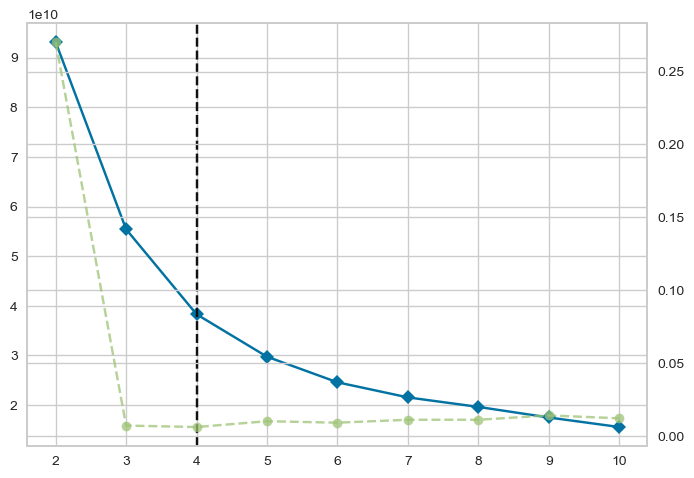

In [9]:
# Now we want to divide customers into cluster based on CLV and predicted NO. purchases and average predicted purchase value

# Firstly, We will see what is the best number for clustering customers into using KElbow method 
kmeans_visulaiser = KElbowVisualizer(KMeans(), k=10)
kmeans_visulaiser.fit(rfm_customers[['pred_num_txn', 'pred_txn_value', 'CLV']])

optimal_clusters = kmeans_visulaiser.elbow_value_

In [10]:
# Secondly, We will divide the customers into clusters based on optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters)
rfm_customers['clusters'] = kmeans.fit_predict(rfm_customers[['pred_num_txn', 'pred_txn_value', 'CLV']])

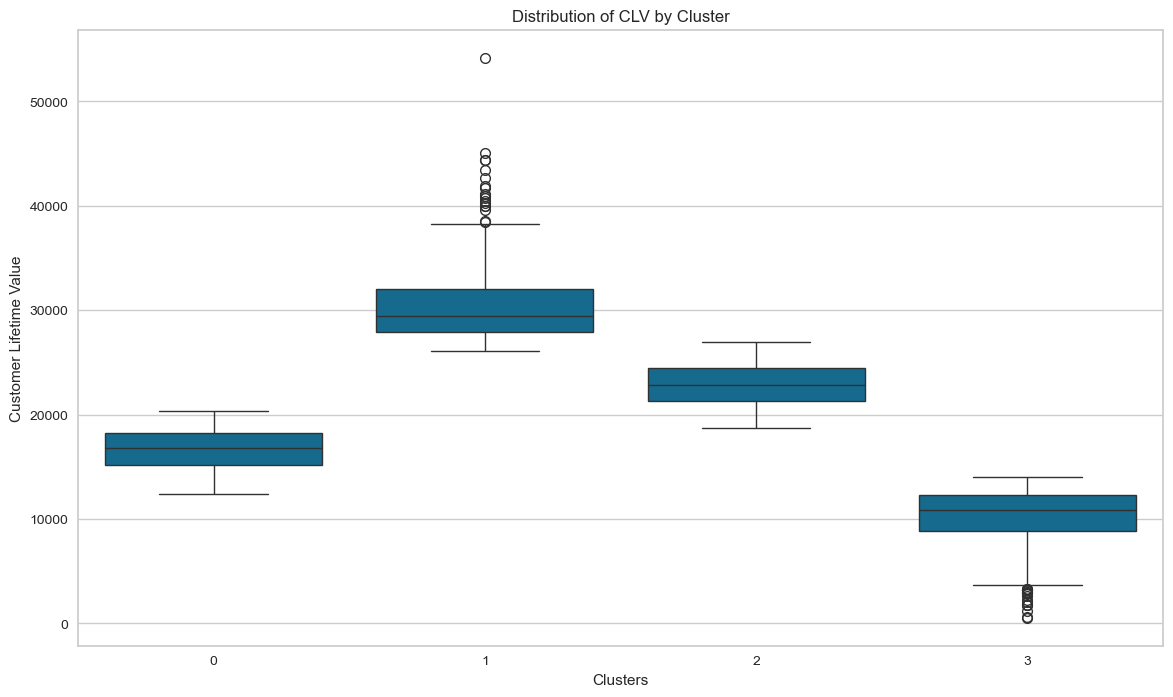

In [11]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='clusters', y='CLV', data=rfm_customers)
plt.title('Distribution of CLV by Cluster')
plt.xlabel('Clusters')
plt.ylabel('Customer Lifetime Value')
plt.show()